# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




# [1]. Reading Data

In [0]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

In [2]:
import sqlite3
from google.colab import drive
drive.mount('/content/drive')
con = sqlite3.connect('/content/drive/My Drive/Asgn/database.sqlite')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# for tsne assignment you can take 5k data points

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 """, con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (525814, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [0]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [5]:
print(display.shape)
display.head()

(80668, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,#oc-R115TNMSPFT9I7,B007Y59HVM,Breyton,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ET0,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3
2,#oc-R11DNU2NBKQ23Z,B007Y59HVM,Kim Cieszykowski,1348531200,1,This coffee is horrible and unfortunately not ...,2
3,#oc-R11O5J5ZVQE25C,B005HG9ET0,Penguin Chick,1346889600,5,This will be the bottle that you grab from the...,3
4,#oc-R12KPBODL2B5ZD,B007OSBE1U,Christopher P. Presta,1348617600,1,I didnt like this coffee. Instead of telling y...,2


In [6]:
display[display['UserId']=='AZY10LLTJ71NX']

,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
80638,AZY10LLTJ71NX,B006P7E5ZI,"undertheshrine ""undertheshrine""",1334707200,5,I was recommended to try green tea extract to ...,5


In [7]:
display['COUNT(*)'].sum()

393063

#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [8]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


In [0]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [10]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(364173, 10)

In [11]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

69.25890143662969

In [12]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [0]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [14]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(364171, 10)


1    307061
0     57110
Name: Score, dtype: int64

#  [3] Preprocessing

## [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [15]:
# printing some random reviews
sent_0 = final['Text'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final['Text'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = final['Text'].values[1500]
print(sent_1500)
print("="*50)

sent_4900 = final['Text'].values[4900]
print(sent_4900)
print("="*50)

this witty little book makes my son laugh at loud. i recite it in the car as we're driving along and he always can sing the refrain. he's learned about whales, India, drooping roses:  i love all the new words this book  introduces and the silliness of it all.  this is a classic book i am  willing to bet my son will STILL be able to recite from memory when he is  in college
I was really looking forward to these pods based on the reviews.  Starbucks is good, but I prefer bolder taste.... imagine my surprise when I ordered 2 boxes - both were expired! One expired back in 2005 for gosh sakes.  I admit that Amazon agreed to credit me for cost plus part of shipping, but geez, 2 years expired!!!  I'm hoping to find local San Diego area shoppe that carries pods so that I can try something different than starbucks.
Great ingredients although, chicken should have been 1st rather than chicken broth, the only thing I do not think belongs in it is Canola oil. Canola or rapeseed is not someting a do

In [16]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_150 = re.sub(r"http\S+", "", sent_1500)
sent_4900 = re.sub(r"http\S+", "", sent_4900)

print(sent_0)

this witty little book makes my son laugh at loud. i recite it in the car as we're driving along and he always can sing the refrain. he's learned about whales, India, drooping roses:  i love all the new words this book  introduces and the silliness of it all.  this is a classic book i am  willing to bet my son will STILL be able to recite from memory when he is  in college


In [17]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1500, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_4900, 'lxml')
text = soup.get_text()
print(text)

this witty little book makes my son laugh at loud. i recite it in the car as we're driving along and he always can sing the refrain. he's learned about whales, India, drooping roses:  i love all the new words this book  introduces and the silliness of it all.  this is a classic book i am  willing to bet my son will STILL be able to recite from memory when he is  in college
I was really looking forward to these pods based on the reviews.  Starbucks is good, but I prefer bolder taste.... imagine my surprise when I ordered 2 boxes - both were expired! One expired back in 2005 for gosh sakes.  I admit that Amazon agreed to credit me for cost plus part of shipping, but geez, 2 years expired!!!  I'm hoping to find local San Diego area shoppe that carries pods so that I can try something different than starbucks.
Great ingredients although, chicken should have been 1st rather than chicken broth, the only thing I do not think belongs in it is Canola oil. Canola or rapeseed is not someting a do

In [0]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [19]:
sent_1500 = decontracted(sent_1500)
print(sent_1500)
print("="*50)

Great ingredients although, chicken should have been 1st rather than chicken broth, the only thing I do not think belongs in it is Canola oil. Canola or rapeseed is not someting a dog would ever find in nature and if it did find rapeseed in nature and eat it, it would poison them. Today is Food industries have convinced the masses that Canola oil is a safe and even better oil than olive or virgin coconut, facts though say otherwise. Until the late 70 is it was poisonous until they figured out a way to fix that. I still like it but it could be better.


In [20]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
print(sent_0)

this witty little book makes my son laugh at loud. i recite it in the car as we're driving along and he always can sing the refrain. he's learned about whales, India, drooping roses:  i love all the new words this book  introduces and the silliness of it all.  this is a classic book i am  willing to bet my son will STILL be able to recite from memory when he is  in college


In [21]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent_1500 = re.sub('[^A-Za-z0-9]+', ' ', sent_1500)
print(sent_1500)

Great ingredients although chicken should have been 1st rather than chicken broth the only thing I do not think belongs in it is Canola oil Canola or rapeseed is not someting a dog would ever find in nature and if it did find rapeseed in nature and eat it it would poison them Today is Food industries have convinced the masses that Canola oil is a safe and even better oil than olive or virgin coconut facts though say otherwise Until the late 70 is it was poisonous until they figured out a way to fix that I still like it but it could be better 


In [0]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [23]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|██████████| 364171/364171 [02:23<00:00, 2543.57it/s]


In [24]:
preprocessed_reviews[600]

'wow works great follow directions get guys pegged three two weeks yard back make sure tap mole runs know active thanks'

In [0]:
final['cleanedText']=preprocessed_reviews

<h2><font color='red'>[3.2] Preprocessing Review Summary</font></h2>

In [0]:
## Similartly you can do preprocessing for review summary also.

In [26]:
#Taking random 60000 ponits for first run
#Taking random 40000 ponits for second run
final_data = final.sample(n=60000)

final_data.shape

(60000, 11)

In [27]:
# Sorting data based on time
final_data["Time"] = pd.to_datetime(final_data["Time"], unit = "s")
final_df = final_data.sort_values(by = "Time")
print(final.shape)
final_df.head(5)

(364171, 11)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,cleanedText
138017,149789,B00004S1C6,A1KXONFPU2XQ5K,Stephanie Manley,26,28,1,2000-08-09,A must have!,"These are easy to use, they do not make a mess...",easy use not make mess offer vibrant colors no...
346102,374408,B00004CI84,A1GB1Q193DNFGR,Bruce Lee Pullen,5,5,1,2000-10-03,Fabulous Comedic Fanasy Directed by a Master,Beetlejuice is an awe-inspiring wonderfully am...,beetlejuice awe inspiring wonderfully amusing ...
346140,374449,B00004CI84,A3K3YJWV0N54ZO,Joey,2,3,1,2001-09-24,"Beetlejuice is a greatmovie, but they cheated ...",Just to warn you. when in trying to trick you ...,warn trying trick widescreen format company ma...
346031,374333,B00004CI84,A1CZICCYP2M5PX,Christian Pelchat,0,0,1,2002-02-07,An entertaining odd fantasy comedy.,When Two Couple (Geena Davis & Alec Baldwin) d...,two couple geena davis alec baldwin died car a...
346114,374420,B00004CI84,A1ZH086GZYL5MZ,Doug DeBolt,2,2,1,2002-02-11,"A little gross, a lot of fun",Michael Keaton was already on his way to being...,michael keaton already way major star played g...


In [0]:
#https://stackoverflow.com/questions/37866450/how-to-extract-word-frequency-from-document-term-matrix/37867872#37867872
#fdist will give you word frequency of given string texts.
#https://stackoverflow.com/questions/9910124/creating-vocabulary-in-python
#https://stackoverflow.com/questions/21852066/counting-word-frequency-and-making-a-dictionary-from-it
#OrderedDict preserves the order in which the keys are inserted. A regular dict doesn’t track the insertion order, and iterating it gives the values in an arbitrary order. By contrast, the order the items are inserted is remembered by OrderedDict.
from nltk import FreqDist
from collections import OrderedDict 
wordin =final_df['cleanedText']
Worddt = FreqDist()
for s in wordin:
    Worddt.update(s.split())


In [0]:
#https://stackoverflow.com/questions/9910124/creating-vocabulary-in-python
#https://stackoverflow.com/questions/21852066/counting-word-frequency-and-making-a-dictionary-from-it
'''
text = '''this is the textfile, and it is used to take words and count'''
for ch in '.\'!")(,;:?-\n':
    text = text.replace(ch, ' ')
wordsArray = text.split(' ')
wordDict = {}
for word in wordsArray:
    if len(word) == 0:
        continue
    else:
        wordDict[word.lower()] = wordDict.get(word.lower(), 0) + 1
print(wordDict)'''

In [0]:
Worddt = OrderedDict(Worddt)

In [0]:
#Indexing the words
def Indexing(row):  
    Sortout = []
    for word in row['cleanedText'].split():
        if word in Worddt:
            Sortout.append(Worddt[word]) 
        else:
            Sortout.append(0)            
    return Sortout

In [0]:
final_df['cleanedText'] = final_df.apply(lambda row: Indexing(row),axis=1)

In [28]:
# 40k data which will use to train model after vectorization
X = final_df['cleanedText']
print("shape of X:", X.shape)
Y = final_df['Score']
print("shape of Y:", Y.shape)

shape of X: (60000,)
shape of Y: (60000,)


In [0]:
X_train = X.sample(40000)
x_test = X.sample(40000)
y_train = Y.sample(40000)
y_test = Y.sample(40000)

In [0]:
from sklearn.model_selection import train_test_split
X_train, x_test, y_train, y_test = train_test_split(X , Y, test_size = 0.5, random_state = 20)

In [30]:
from keras.preprocessing.text import Tokenizer
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)

Using TensorFlow backend.


In [0]:
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(x_test)

In [0]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.regularizers import L1L2
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from keras.layers import Dropout 
from keras.layers import Dense, Activation 

In [0]:
#Padding 
review_length = 500
X_train = sequence.pad_sequences(X_train, maxlen=review_length)
x_test = sequence.pad_sequences(X_test, maxlen=review_length)

**Training LSTM models**

In [0]:
batch_size = 64
wordcount=4000
nb_epoch = 10
voc_size = (X_train.max()+1).astype('int64')
reg = L1L2(0.01, 0.01)

In [46]:
# Multilayer perceptron
model = Sequential()
model.add(Embedding(voc_size, 64)) 
model.add(LSTM(64))
model.add(Dense(1, activation='sigmoid'))
model.add(Dropout(0.5))
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, None, 64)          320000    
_________________________________________________________________
lstm_5 (LSTM)                (None, 64)                33024     
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 65        
_________________________________________________________________
dropout_3 (Dropout)          (None, 1)                 0         
Total params: 353,089
Trainable params: 353,089
Non-trainable params: 0
_________________________________________________________________
None


In [47]:
history = model.fit(X_train, y_train, batch_size=batch_size, epochs=nb_epoch, verbose=1, validation_data=(x_test, y_test)) 

Train on 40000 samples, validate on 40000 samples
Epoch 1/10
40000/40000 [==============================] - 378s 9ms/step - loss: 6.9701 - acc: 0.5006 - val_loss: 0.8402 - val_acc: 0.1609
Epoch 2/10
40000/40000 [==============================] - 375s 9ms/step - loss: 7.0145 - acc: 0.4978 - val_loss: 0.8099 - val_acc: 0.1611
Epoch 3/10
40000/40000 [==============================] - 374s 9ms/step - loss: 7.0254 - acc: 0.4972 - val_loss: 0.7987 - val_acc: 0.1670
Epoch 4/10
40000/40000 [==============================] - 374s 9ms/step - loss: 6.9233 - acc: 0.5036 - val_loss: 0.8338 - val_acc: 0.1676
Epoch 5/10
40000/40000 [==============================] - 375s 9ms/step - loss: 7.0045 - acc: 0.4990 - val_loss: 0.8282 - val_acc: 0.1615
Epoch 6/10
40000/40000 [==============================] - 374s 9ms/step - loss: 6.9781 - acc: 0.5020 - val_loss: 0.8396 - val_acc: 0.1706
Epoch 7/10
40000/40000 [==============================] - 377s 9ms/step - loss: 6.9260 - acc: 0.5060 - val_loss: 0.8312 - 

In [0]:
def plt_dynamic(x, vy, ty, ax, colors=['b']):
    ax.plot(x, vy, 'b', label="Validation Loss")
    ax.plot(x, ty, 'r', label="Train Loss")
    plt.legend()
    plt.grid()
    fig.canvas.draw()

Test score: 0.8573040187835693
Test accuracy: 0.1855


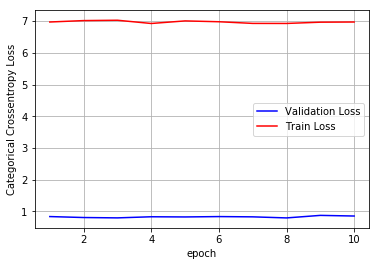

In [49]:
score = model.evaluate(x_test, y_test, verbose=0) 
print('Test score:', score[0]) 
print('Test accuracy:', score[1])

fig,ax = plt.subplots(1,1)
ax.set_xlabel('epoch') ; ax.set_ylabel('Categorical Crossentropy Loss')

# list of epoch numbers
x = list(range(1,nb_epoch+1))

# print(history.history.keys())
# dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])
# history = model_drop.fit(X_train, Y_train, batch_size=batch_size, epochs=nb_epoch, verbose=1, validation_data=(X_test, Y_test))

# we will get val_loss and val_acc only when you pass the paramter validation_data
# val_loss : validation loss
# val_acc : validation accuracy

# loss : training loss
# acc : train accuracy
# for each key in histrory.histrory we will have a list of length equal to number of epochs

vy = history.history['val_loss']
ty = history.history['loss']
plt_dynamic(x, vy, ty, ax)

In [0]:
batch_size = 8
wordcount=4000
nb_epoch = 10
voc_size = (X_train.max()+1).astype('int64')
reg = L1L2(0.01, 0.01)

In [0]:
# Multilayer perceptron
model_lstm = Sequential()
model_lstm.add(Embedding(voc_size, 32)) 
model_lstm.add(LSTM(32))
model_lstm.add(Dense(1, activation='sigmoid'))

model_lstm.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [52]:
history1 = model_lstm.fit(X_train, y_train, batch_size=batch_size, epochs=nb_epoch, verbose=1, validation_data=(x_test, y_test)) 

Train on 40000 samples, validate on 40000 samples
Epoch 1/10
40000/40000 [==============================] - 1294s 32ms/step - loss: 0.4429 - acc: 0.8393 - val_loss: 0.4428 - val_acc: 0.8391
Epoch 2/10
40000/40000 [==============================] - 1290s 32ms/step - loss: 0.4361 - acc: 0.8394 - val_loss: 0.4462 - val_acc: 0.8391
Epoch 3/10
40000/40000 [==============================] - 1293s 32ms/step - loss: 0.4108 - acc: 0.8397 - val_loss: 0.4628 - val_acc: 0.8386
Epoch 4/10
40000/40000 [==============================] - 1277s 32ms/step - loss: 0.3831 - acc: 0.8437 - val_loss: 0.5035 - val_acc: 0.8276
Epoch 5/10
40000/40000 [==============================] - 1276s 32ms/step - loss: 0.3547 - acc: 0.8539 - val_loss: 0.5188 - val_acc: 0.8123
Epoch 6/10
40000/40000 [==============================] - 1268s 32ms/step - loss: 0.3188 - acc: 0.8661 - val_loss: 0.5937 - val_acc: 0.7933
Epoch 7/10
40000/40000 [==============================] - 1265s 32ms/step - loss: 0.2805 - acc: 0.8822 - val_l

Test score: 0.9903181386470795
Test accuracy: 0.75515


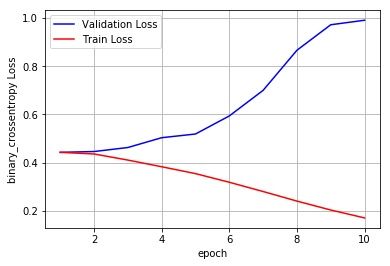

In [53]:
score = model_lstm.evaluate(x_test, y_test, verbose=0) 
print('Test score:', score[0]) 
print('Test accuracy:', score[1])

fig,ax = plt.subplots(1,1)
ax.set_xlabel('epoch') ; ax.set_ylabel('binary_crossentropy Loss')

# list of epoch numbers
x = list(range(1,nb_epoch+1))

# print(history.history.keys())
# dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])
# history = model_drop.fit(X_train, Y_train, batch_size=batch_size, epochs=nb_epoch, verbose=1, validation_data=(X_test, Y_test))

# we will get val_loss and val_acc only when you pass the paramter validation_data
# val_loss : validation loss
# val_acc : validation accuracy

# loss : training loss
# acc : train accuracy
# for each key in histrory.histrory we will have a list of length equal to number of epochs

vy = history1.history['val_loss']
ty = history1.history['loss']
plt_dynamic(x, vy, ty, ax)

In [0]:
batch_size = 16
wordcount=4000
nb_epoch = 5
voc_size = (X_train.max()+1).astype('int64')
reg = L1L2(0.01, 0.01)

In [0]:
# Multilayer perceptron
model_lstm1 = Sequential()
model_lstm1.add(Embedding(voc_size, 64)) 
model_lstm1.add(LSTM(64))
model_lstm1.add(Dense(1, activation='tanh'))

model_lstm1.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])


In [58]:
history2 = model_lstm1.fit(X_train, y_train, batch_size=batch_size, epochs=nb_epoch, verbose=1, validation_data=(x_test, y_test)) 

Train on 40000 samples, validate on 40000 samples
Epoch 1/5
40000/40000 [==============================] - 875s 22ms/step - loss: 0.4617 - acc: 0.8341 - val_loss: 0.4445 - val_acc: 0.8391
Epoch 2/5
40000/40000 [==============================] - 869s 22ms/step - loss: 0.4323 - acc: 0.8393 - val_loss: 0.4551 - val_acc: 0.8390
Epoch 3/5
40000/40000 [==============================] - 878s 22ms/step - loss: 0.3955 - acc: 0.8424 - val_loss: 0.4940 - val_acc: 0.8261
Epoch 4/5
40000/40000 [==============================] - 884s 22ms/step - loss: 0.3554 - acc: 0.8526 - val_loss: 0.5564 - val_acc: 0.8071
Epoch 5/5
40000/40000 [==============================] - 884s 22ms/step - loss: 0.3164 - acc: 0.8661 - val_loss: 0.6418 - val_acc: 0.8027


Test score: 0.6417999728322029
Test accuracy: 0.8027


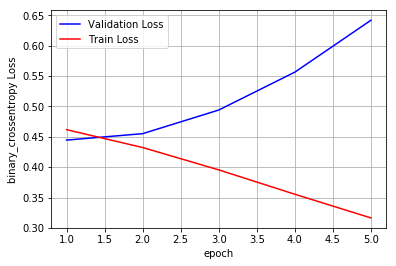

In [59]:
score = model_lstm1.evaluate(x_test, y_test, verbose=0) 
print('Test score:', score[0]) 
print('Test accuracy:', score[1])

fig,ax = plt.subplots(1,1)
ax.set_xlabel('epoch') ; ax.set_ylabel('binary_crossentropy Loss')

# list of epoch numbers
x = list(range(1,nb_epoch+1))

# print(history.history.keys())
# dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])
# history = model_drop.fit(X_train, Y_train, batch_size=batch_size, epochs=nb_epoch, verbose=1, validation_data=(X_test, Y_test))

# we will get val_loss and val_acc only when you pass the paramter validation_data
# val_loss : validation loss
# val_acc : validation accuracy

# loss : training loss
# acc : train accuracy
# for each key in histrory.histrory we will have a list of length equal to number of epochs

vy = history2.history['val_loss']
ty = history2.history['loss']
plt_dynamic(x, vy, ty, ax)

In [60]:

from prettytable import PrettyTable
    
p = PrettyTable()

p.field_names = ["Model", "Accuracy",  ]

p.add_row([" Sigmoid activation + ADAM", 0.189, ] )
p.add_row([" tanh activation + ADAM", 0.75, ] )
p.add_row([" tanh activation + ADAM", 0.82, ] )
print(p)

+----------------------------+----------+
|           Model            | Accuracy |
+----------------------------+----------+
|  Sigmoid activation + ADAM |  0.189   |
|   tanh activation + ADAM   |   0.75   |
|   tanh activation + ADAM   |   0.82   |
+----------------------------+----------+


## **Observations:**

Trained dataset which was converted into a dictionary format. Indexing is done. MLP is modelled using LSTM layer. Different combination are tested.